## 1. Setup and Installation
Install the necessary libraries: `roboflow` for dataset management and `ultralytics` for the model.

In [1]:
!pip install roboflow ultralytics matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## 2. Download Data from Roboflow
We will download the dataset using the Roboflow API.

In [12]:
from roboflow import Roboflow
import os

# --- CONFIGURATION ---
API_KEY = 'fNh37dV1D0lUqlJYGKHa'
WORKSPACE = "jennifers-almost-paradise"
PROJECT = "skin-ga5ww-asjno"
VERSION = 1 # We assume version 1, change if you are using a specific version
# ---------------------

try:
    rf = Roboflow(api_key=API_KEY)
    project = rf.workspace(WORKSPACE).project(PROJECT)
    dataset = project.version(VERSION).download("folder")
    dataset_path = dataset.location
    print(f"\n Dataset downloaded to: {dataset_path}")
except Exception as e:
    print("\n Error downloading dataset. Please check your API Key and Project permissions.")
    print(e)

loading Roboflow workspace...
loading Roboflow project...
Exporting format folder in progress : 85.0%
Version export complete for folder format



Extracting Dataset Version Zip to skin-1 in folder:: 100%|██████████| 17305/17305 [00:01<00:00, 9653.06it/s]


 Dataset downloaded to: /content/skin-1


## 3. Dataset Exploration & Analysis
Here we write a custom script to walk through the folders, count the images, and analyze the distribution.

Analyzing dataset at: /content/skin-1...

 Dataset Statistics:
Total Images: 17294
Classes Detected: ['Basal Cell Carcinoma' 'Melanoma']

Breakdown by Split and Class:
Split                 test  train  valid
Class                                   
Basal Cell Carcinoma   358   7527    717
Melanoma               362   7605    725


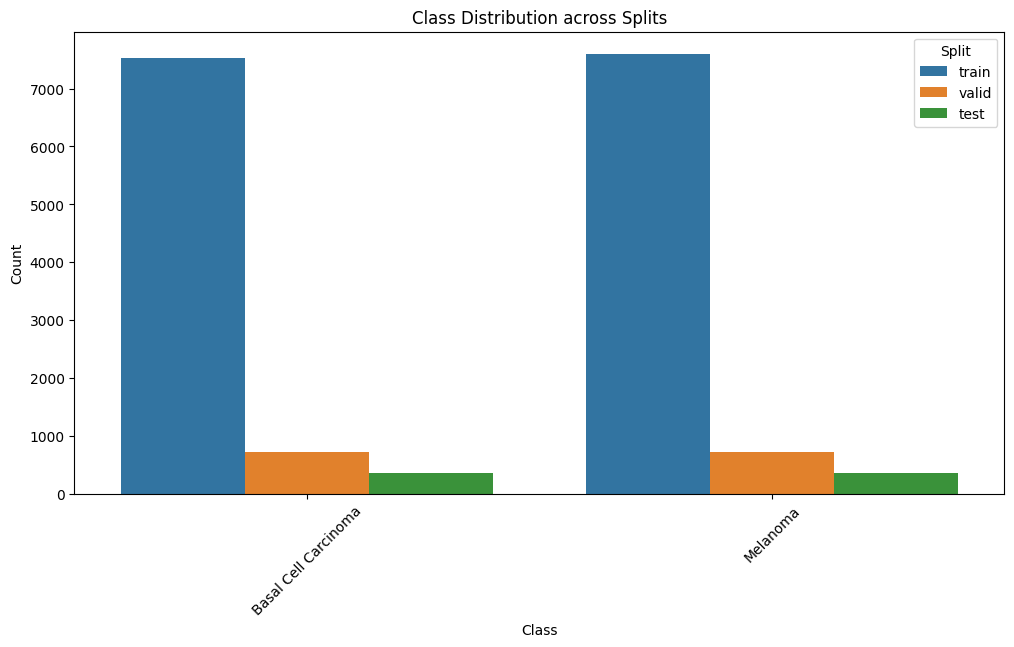


 Sample Images (One per class from Train split):


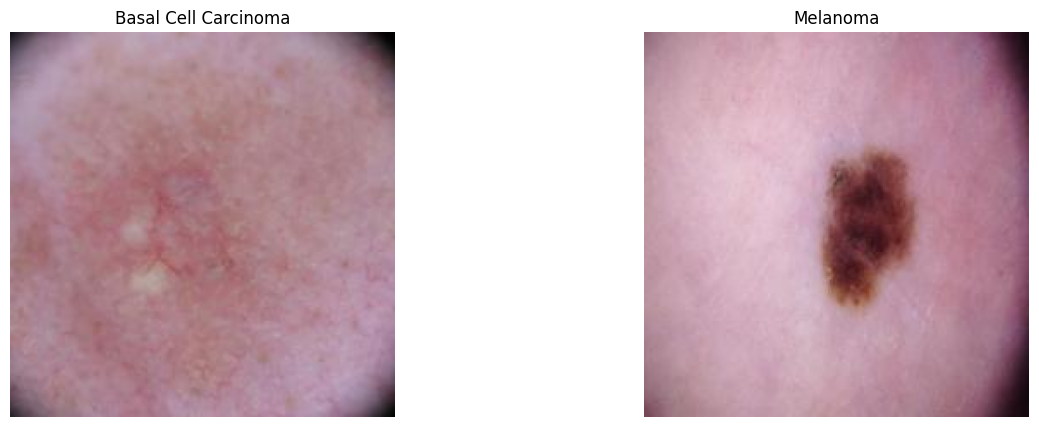

In [13]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import random

def explore_dataset(root_path):
    splits = ['train', 'valid', 'test']
    data_stats = []

    # 1. Parse Directory Structure
    print(f"Analyzing dataset at: {root_path}...")

    for split in splits:
        split_path = os.path.join(root_path, split)
        if not os.path.exists(split_path):
            print(f"Split '{split}' not found (Roboflow sometimes names valid as 'valid' or 'val')")
            # Try alternative name for validation
            if split == 'valid':
                split_path = os.path.join(root_path, 'val')
                if os.path.exists(split_path):
                    split = 'val'
                else:
                    continue
            else:
                continue

        # Get classes (subfolders)
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]

        for cls in classes:
            class_path = os.path.join(split_path, cls)
            num_images = len(glob.glob(os.path.join(class_path, '*.*')))
            data_stats.append({'Split': split, 'Class': cls, 'Count': num_images})

    df = pd.DataFrame(data_stats)

    # 2. Display Statistics
    if df.empty:
        print("No data found. Check the dataset path.")
        return

    print("\n Dataset Statistics:")
    total_images = df['Count'].sum()
    print(f"Total Images: {total_images}")
    print(f"Classes Detected: {df['Class'].unique()}")
    print("\nBreakdown by Split and Class:")
    print(df.pivot(index='Class', columns='Split', values='Count').fillna(0))

    # 3. Check for Imbalance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Class', y='Count', hue='Split')
    plt.title('Class Distribution across Splits')
    plt.xticks(rotation=45)
    plt.show()

    # 4. Visualize Samples
    print("\n Sample Images (One per class from Train split):")
    train_split = 'train'
    classes = df[df['Split'] == train_split]['Class'].unique()

    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    if len(classes) == 1: axes = [axes]

    for i, cls in enumerate(classes):
        cls_path = os.path.join(root_path, train_split, cls)
        images = glob.glob(os.path.join(cls_path, '*.*'))
        if images:
            img_path = random.choice(images)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(cls)
            axes[i].axis('off')
    plt.show()

# Run exploration
if 'dataset_path' in locals():
    explore_dataset(dataset_path)
else:
    print("Please download the dataset first.")

## 4. Train YOLO11 Model

In [14]:
from ultralytics import YOLO

model = YOLO('yolo11n-cls.pt')

# Train the model

results = model.train(
    data=dataset_path,
    epochs=20,
    imgsz=224,
    project="skin_disease_project",
    name="yolo11n_skin_cls"
)

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/skin-1, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_skin_cls2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

Displaying training/validation curves from: /content/skin_disease_project/yolo11n_skin_cls2/results.png


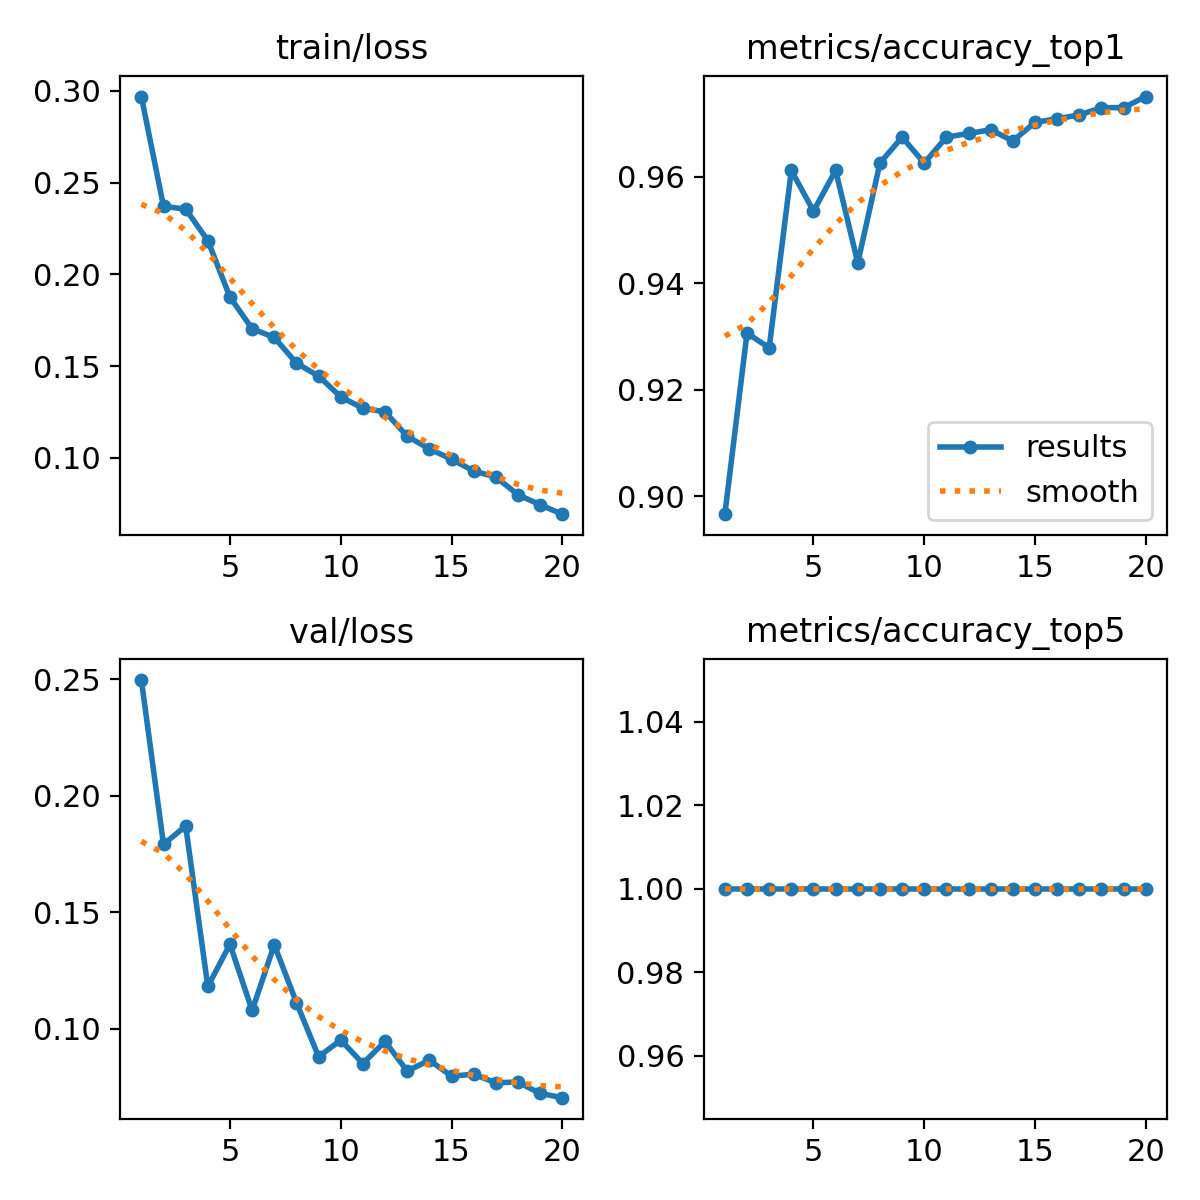

In [21]:
from IPython.display import Image, display
import os

# The training results were saved to 'skin_disease_project/yolo11n_skin_cls2'
# as indicated by the output of the model.train() function.
# The training curves (loss/accuracy) are typically saved as 'results.png' in this directory.

experiment_dir = '/content/skin_disease_project/yolo11n_skin_cls2'
results_plot_path = os.path.join(experiment_dir, 'results.png')

if os.path.exists(results_plot_path):
    print(f"Displaying training/validation curves from: {results_plot_path}")
    display(Image(filename=results_plot_path))
else:
    print(f"Training/Validation curves not found at {results_plot_path}. Please ensure the model was trained and saved the plots.")

## 5. Validate and Inference

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/skin-1/train... found 15132 images in 2 classes ✅ 
val: /content/skin-1/valid... found 1442 images in 2 classes ✅ 
test: /content/skin-1/test... found 720 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 359.8±158.6 MB/s, size: 7.0 KB)
val: Scanning /content/skin-1/valid... 1442 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1442/1442 3.0Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 91/91 22.7it/s 4.0s
                   all      0.975          1
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val5
Top-1 Accuracy: 0.9750346541404724
Top-5 Accuracy: 1.0

image 1/1 /content/skin-1/test/Melanoma/ISIC_7181296_jpg.rf.71b78b24e805084cb01a2701e0bd6931.jpg: 224x224 Melanoma 0.91, Basal Cell Carcinoma 0.09, 4.9ms
Speed: 3.7ms preprocess, 4.9ms inference, 0.1ms postprocess per image 

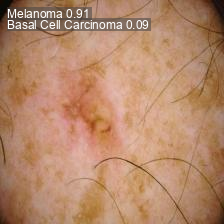

Prediction: Melanoma (0.91)


In [22]:
# Validate on the test/val set automatically included in the dataset folder
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1}")
print(f"Top-5 Accuracy: {metrics.top5}")

# Run Inference on a random image from the test set
import glob
import random

test_images = glob.glob(f"{dataset_path}/test/*/*.*")
if test_images:
    test_image = random.choice(test_images)

    # Predict
    results = model.predict(test_image)

    # Show results
    for result in results:
        result.show()  # Display the image with class label
        print(f"Prediction: {result.names[result.probs.top1]} ({result.probs.top1conf:.2f})")
else:
    print("No test images found.")

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/skin-1/train... found 15132 images in 2 classes ✅ 
val: /content/skin-1/valid... found 1442 images in 2 classes ✅ 
test: /content/skin-1/test... found 720 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 260.7±84.8 MB/s, size: 7.0 KB)
val: Scanning /content/skin-1/valid... 1442 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1442/1442 3.0Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 91/91 30.5it/s 3.0s
                   all      0.975          1
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val6
Top-1 Accuracy: 0.9750346541404724
Top-5 Accuracy: 1.0

image 1/1 /content/skin-1/test/Melanoma/ISIC_7168543_jpg.rf.ada6d5fb9fc06391201271955b56aa6b.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 4.1ms
Speed: 2.9ms preprocess, 4.1ms inference, 0.1ms postprocess per image a

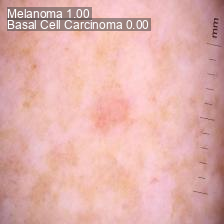

Prediction: Melanoma (1.00)

image 1/1 /content/skin-1/test/Melanoma/ISIC_7115931_jpg.rf.c2e1cca89f9e28fd56e0e8ffe3eec4f6.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 5.7ms
Speed: 2.9ms preprocess, 5.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


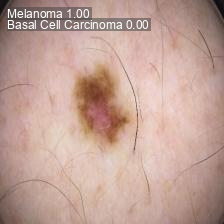

Prediction: Melanoma (1.00)

image 1/1 /content/skin-1/test/Melanoma/ISIC_7429127_jpg.rf.a2b61f0606e76d14c00c3f948df19d46.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 5.8ms
Speed: 2.7ms preprocess, 5.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


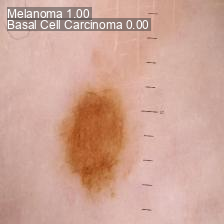

Prediction: Melanoma (1.00)

image 1/1 /content/skin-1/test/Basal Cell Carcinoma/ISIC_0133379_jpg.rf.bbe8d94595bce24ed036c55273cdc2d3.jpg: 224x224 Basal Cell Carcinoma 0.92, Melanoma 0.08, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


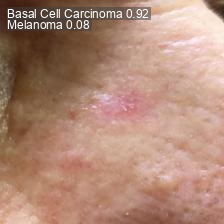

Prediction: Basal Cell Carcinoma (0.92)

image 1/1 /content/skin-1/test/Melanoma/ISIC_0066408_JPG.rf.1c30e4c59bc3a55ee9a9ad1de5518e3f.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 5.5ms
Speed: 2.4ms preprocess, 5.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


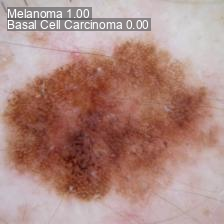

Prediction: Melanoma (1.00)


In [23]:
metrics = model.val()
print(f"Top-1 Accuracy: {metrics.top1}")
print(f"Top-5 Accuracy: {metrics.top5}")

# Run Inference on a random image from the test set
import glob
import random

for i in range(5):
  test_images = glob.glob(f"{dataset_path}/test/*/*.*")
  if test_images:
      test_image = random.choice(test_images)

      # Predict
      results = model.predict(test_image)

      # Show results
      for result in results:
          result.show()  # Display the image with class label
          print(f"Prediction: {result.names[result.probs.top1]} ({result.probs.top1conf:.2f})")
  else:
      print("No test images found.")


Performing inference on 3 random test images:

--- Inference on Image 1 ---

image 1/1 /content/skin-1/test/Melanoma/ISIC_6708310_jpg.rf.1ec658aab010df2acfce0a0fba1bbf02.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 6.1ms
Speed: 2.3ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


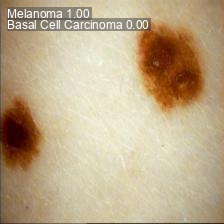

Prediction: Melanoma (Confidence: 1.00)

--- Inference on Image 2 ---

image 1/1 /content/skin-1/test/Melanoma/ISIC_6938682_jpg.rf.2c58b16183a04fab0d8b428de670f6bc.jpg: 224x224 Melanoma 1.00, Basal Cell Carcinoma 0.00, 5.0ms
Speed: 2.6ms preprocess, 5.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


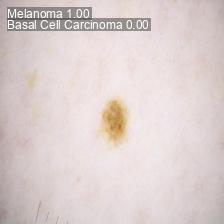

Prediction: Melanoma (Confidence: 1.00)

--- Inference on Image 3 ---

image 1/1 /content/skin-1/test/Basal Cell Carcinoma/ISIC_0068302_jpg.rf.10ae1397ea8857982aad58f3f0a78007.jpg: 224x224 Basal Cell Carcinoma 1.00, Melanoma 0.00, 5.5ms
Speed: 4.3ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


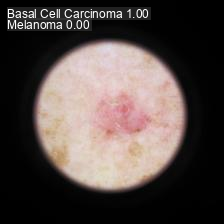

Prediction: Basal Cell Carcinoma (Confidence: 1.00)


In [17]:
import glob
import random

# Get all test images
test_images = glob.glob(f"{dataset_path}/test/*/*.*")

if test_images:
    print("\nPerforming inference on 3 random test images:")
    # Select 3 random images for inference
    selected_images = random.sample(test_images, min(3, len(test_images)))

    for i, img_path in enumerate(selected_images):
        print(f"\n--- Inference on Image {i+1} ---")
        # Predict
        results = model.predict(img_path)

        # Show results
        for result in results:
            result.show()  # Display the image with class label
            print(f"Prediction: {result.names[result.probs.top1]} (Confidence: {result.probs.top1conf:.2f})")
else:
    print("No test images found for inference.")

Displaying confusion matrix from: /content/runs/classify/val4/confusion_matrix.png


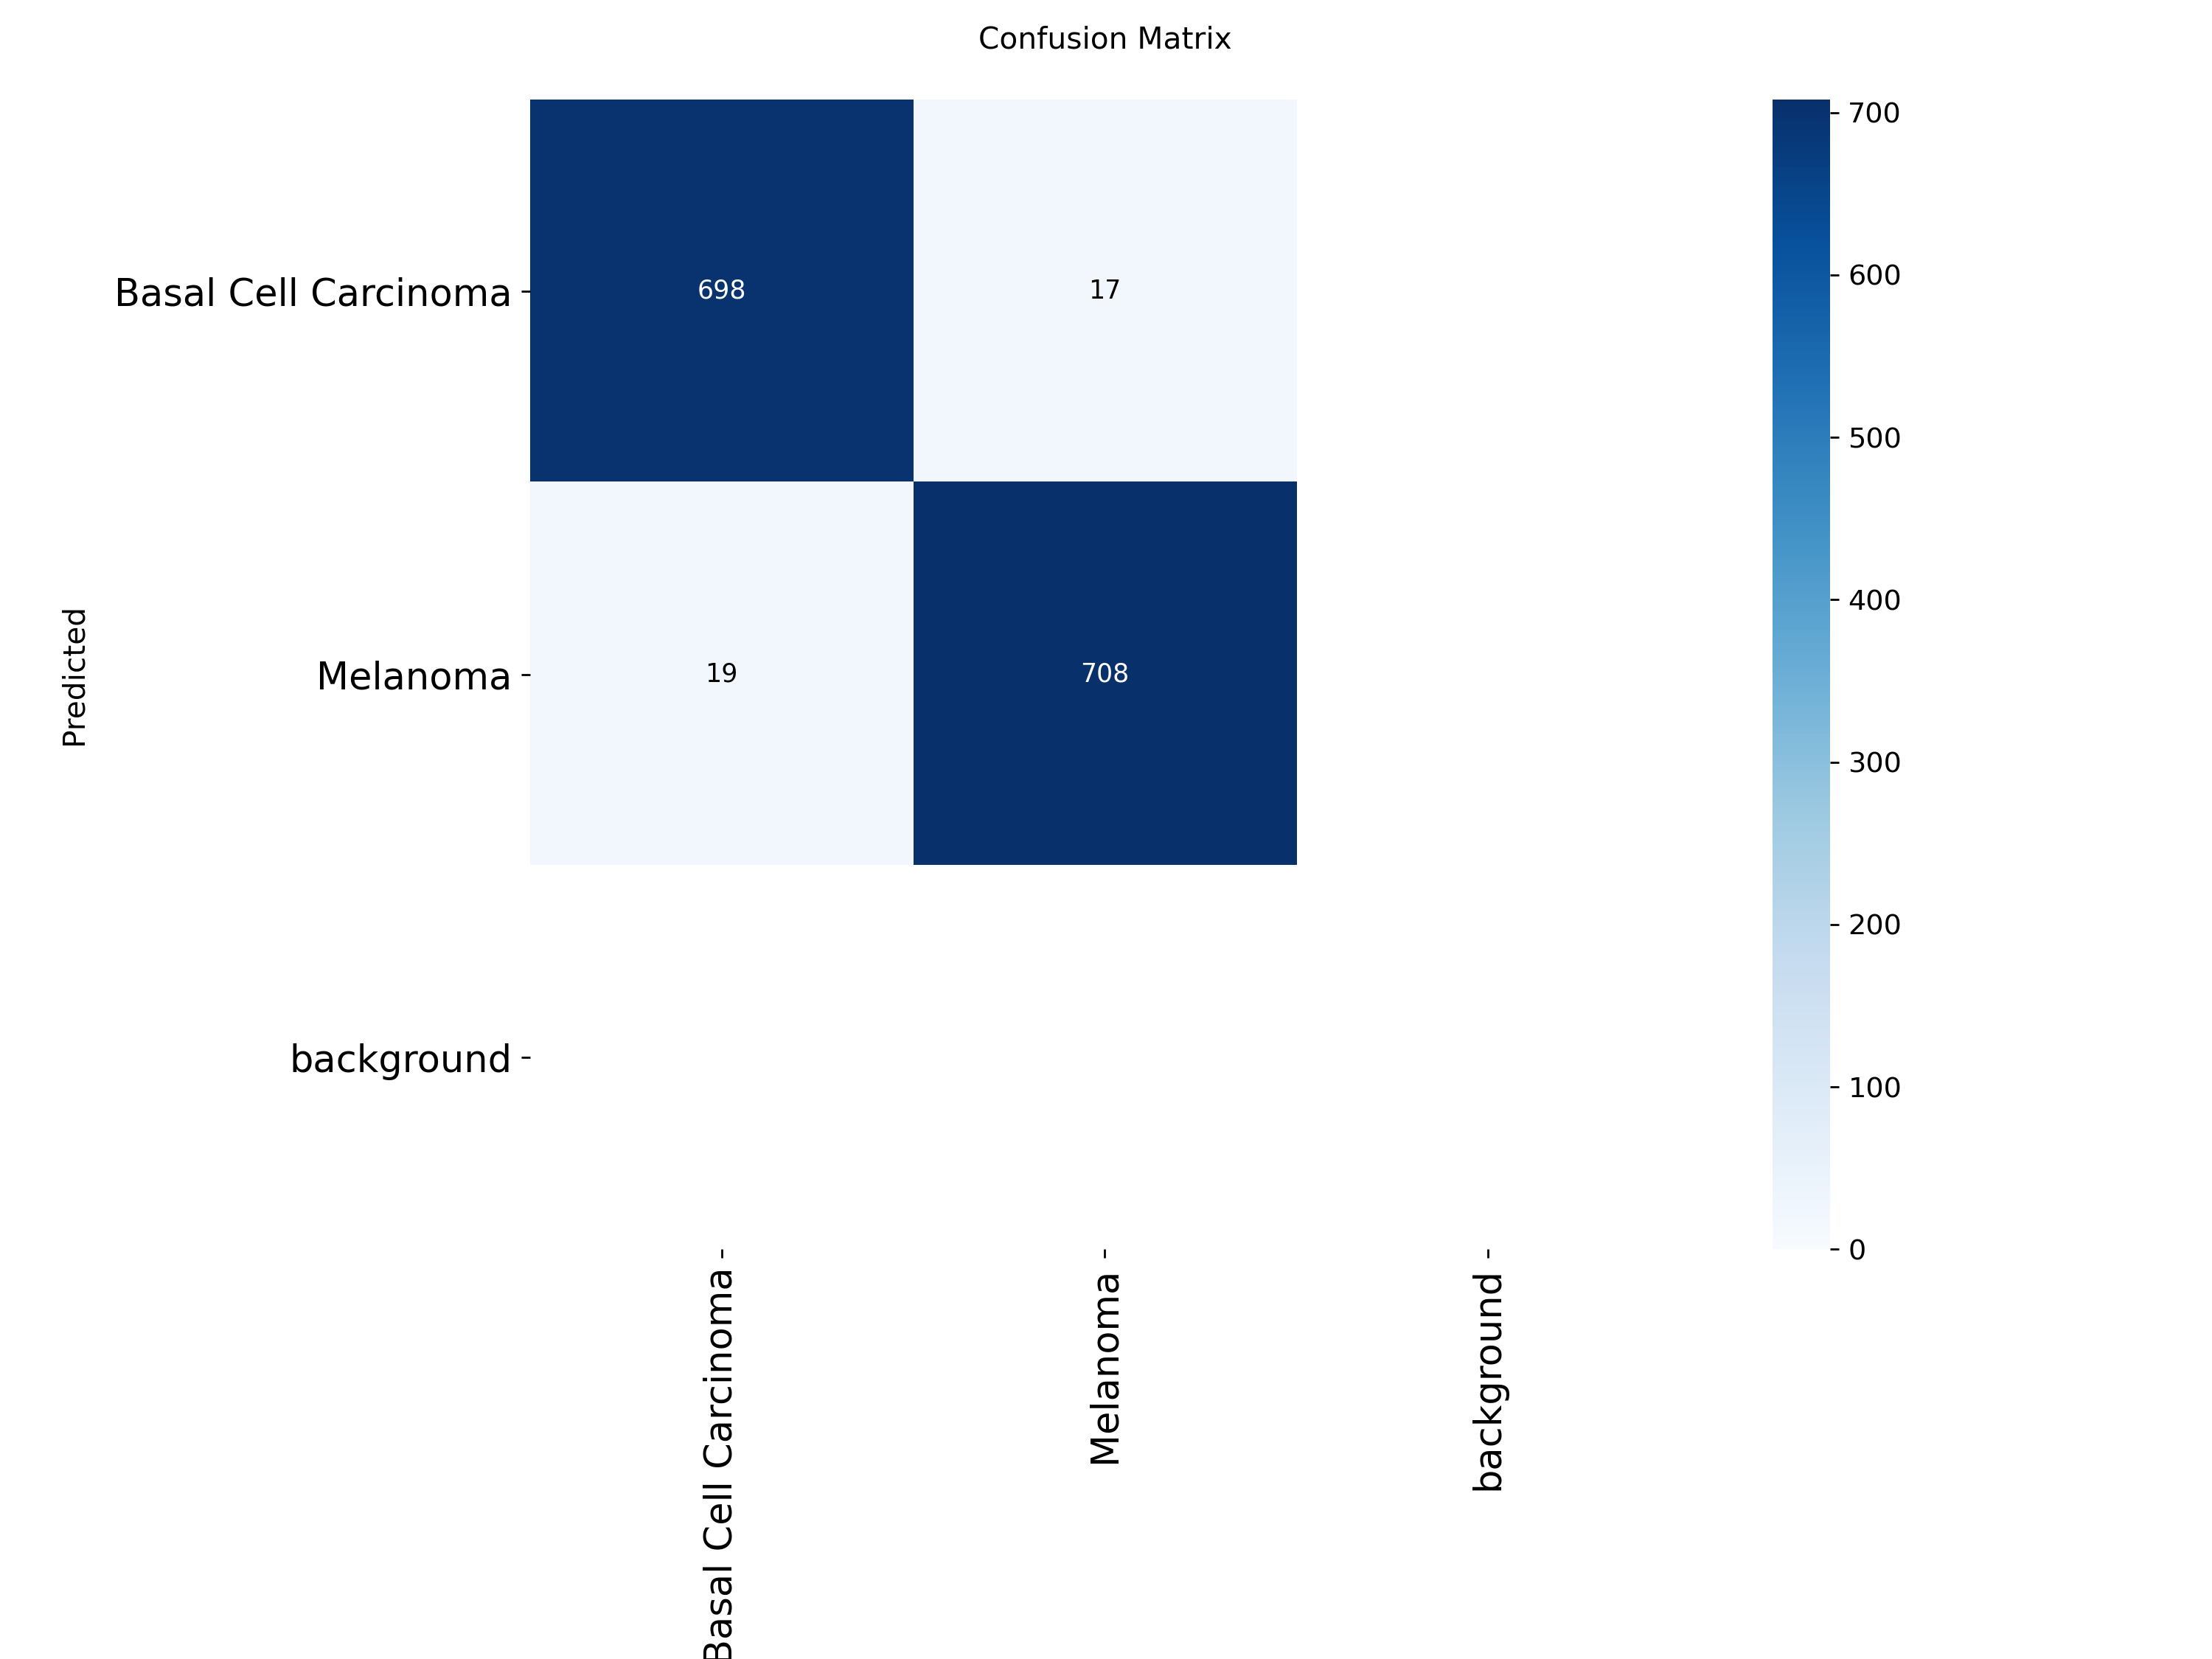

In [24]:
from IPython.display import Image, display
import os

results_dir = '/content/runs/classify/val4'
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')

if os.path.exists(confusion_matrix_path):
    print(f"Displaying confusion matrix from: {confusion_matrix_path}")
    display(Image(filename=confusion_matrix_path))
else:
    print(f"Confusion matrix not found at {confusion_matrix_path}. Please ensure the model was validated and saved the plots.")